In [1]:
import numpy as np
from scipy.linalg import norm, eigh, eig
from scipy.sparse import lil_matrix
# from scipy.sparse.linalg import eigsh as speigsh
from scipy.sparse.linalg import eigs as speigs
from scipy.sparse.linalg import norm as spnorm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from matplotlib.colors import Normalize

# Utility & Logging
import os
import time
import sys
import logbook
from logbook import Logger, StreamHandler, FileHandler, DEBUG, INFO, WARNING, ERROR, NOTSET
from tqdm.notebook import tqdm
import warnings

In [2]:
np.random.seed(42)

DATA_PATH = 'data/ex3'
MEDIA_PATH = 'media/ex3'
LOG_PATH = 'log'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MEDIA_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)

LOAD_CACHED_FILES_IF_AVAILABLE = True

log = Logger('Set 3 Logger')
fh = FileHandler(f'{LOG_PATH}/ex3_1_1.log', mode='w', level=DEBUG, bubble=True)
fh.push_application()
warnings.filterwarnings('ignore')

Function to generate five-point stencil to discretize Laplacian

In [3]:
def fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, radius=None, sparse=False):
    '''
    Creates a five-point stencil finite difference matrix M to approximate the Laplacian operator in eigenvalue problem.
    Excludes the boundary points as they are stationary.

    Args:
        nx (int): Number of grid points in the x direction.
        ny (int): Number of grid points in the y direction.
        radius (float): Radius of the circular mask in the original spatial dimensions.

    Returns:
        np.ndarray: The five-point stencil finite difference matrix M for the inner points.
    '''
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    nx, ny = Nx - 2, Ny - 2
    N = nx * ny  # Excluding boundary points
    if sparse:
        M = lil_matrix((N, N))
    else:
        M = np.zeros((N, N))

    circle_mask = None
    if radius is not None:
        # Create mask for the circular region
        circle_mask = np.zeros((nx, ny))
        x, y = np.meshgrid(np.linspace(-Lx/2, Lx/2, nx), np.linspace(-Ly/2, Ly/2, ny))
        circle_mask = np.where(x**2 + y**2 <= radius**2, 0, 1)

    for x in range(nx):
        for y in range(ny):
            if circle_mask is not None and circle_mask[x, y]:
                continue

            index = x * ny + y
            M[index, index] = -2 / dx**2 - 2 / dy**2

            if x > 0:
                M[index, index - ny] = 1 / dx**2
            if x < nx - 1:
                M[index, index + ny] = 1 / dx**2

            if y > 0:
                M[index, index - 1] = 1 / dy**2
            if y < ny - 1:
                M[index, index + 1] = 1 / dy**2

    if sparse:
        M = M.tocsr()
    return M
    
def size_in_bytes(M):
    '''
    Returns the size of the matrix M in bytes.
    '''
    if isinstance(M, np.ndarray):
        return M.nbytes
    elif hasattr(M, 'data'):
        return M.data.nbytes + M.indptr.nbytes + M.indices.nbytes
    else:
        raise NotImplementedError('Unknown matrix type')

    
def add_boundary_to_eigvec(eigvec, nx, ny):
    '''
    Adds the edges back to the eigenvector eigvec.
    '''
    log.debug('Adding boundary to eigenvector.')
    Nx, Ny = nx + 2, ny + 2
    eigvec_full = np.zeros((Nx, Ny))
    eigvec_full[1:-1, 1:-1] = eigvec.reshape(nx, ny)
    return eigvec_full

def solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=None, sort_order='ascending', sparse=False, k=3, which='largest'):
    '''
    Solves the eigenvalue problem Mv = Kv for the matrix M, here a finite difference approximation of the Laplacian operator.

    Args:
        Nx (int): Number of discretization points in x.
        Ny (int): Number of discretization points in y.
        Lx (float): Length of the object in x.
        Ly (float): Length of the object in y.
        sort_order (str): The order in which to sort returned values, either `ascending` or `descending`.
        sparse (bool): Whether to use sparse mode.
        sparse_k (int): The number of eigenvalues to compute (in sparse mode only).
        sparse_which (str): Which eigenvalues to compute (in sparse mode only).

    Returns:
        np.ndarray: The finite difference matrix M.
        np.ndarray: The eigenvalues K.
        np.ndarray: The eigenvectors v.
        np.ndarray: The eigenfrequencies f.
    '''
    nx, ny = Nx-2, Ny-2
    N = nx * ny
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)

    M = fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, sparse=sparse, radius=radius)
    log.info(f'Solving eigenvector problem Mv = Kv for the finite difference matrix M of size ({M.shape[0]},{M.shape[1]}).')

    if sparse:
        if k is None:
            log.error('sparse_k should be provided if sparse is True. Using N-2 as default, but this may be slow.')
            k = N-2
        if which is None:
            log.error('sparse_which should be provided if sparse is True. Using "LE" as default, but this may not be the intended result.')
            which = 'LE'
        eigvals, eigvecs = speigs(M, k=k, which=which)
    else:
        eigvals, eigvecs = eig(M)

    log.info(f'Sorting eigenvalues and vectors in {sort_order} order.')
    # Sort the eigenvalues and eigenvectors
    if sort_order == 'ascending':
        sort_indices = np.argsort(eigvals)
    elif sort_order == 'descending':
        sort_indices = np.argsort(-eigvals)
    else:
        raise ValueError('sort_order must be "ascending" or "descending"')
    
    eigvals, eigvecs = eigvals[sort_indices], eigvecs[:, sort_indices]
    eigfreqs = np.array(np.sqrt(-eigvals), dtype=int) # ignore imaginary component
    
    return M, eigvals, eigvecs, eigfreqs

def vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), title=None, titlesize=14):
    plx, ply = plot_shape
    plratio = Nx/Ny
    nx, ny = Nx-2, Ny-2
    fig, axs = plt.subplots(plx, ply, figsize=(10*plratio, 4), constrained_layout=True)
    if title:
        fig.suptitle(title, y=1.05, fontsize=titlesize)
    else:
        fig.suptitle(f'Eigenmodes for a drum of size $L_x={Lx}, L_y={Ly}$ with $c=1$', y=1.05, fontsize=titlesize)
    images = []
    
    vmin = np.min(eigvecs[:, :len(axs.flatten())])
    vmax = np.max(eigvecs[:, :len(axs.flatten())])
    max_v = max(abs(vmin), abs(vmax))
    norm = Normalize(vmin=-max_v, vmax=max_v)

    for i, ax in enumerate(axs.flatten()):
        eigvec, eigval, eigfreq = eigvecs[:, i], eigvals[i], eigfreqs[i]
        eigvec = np.rot90(add_boundary_to_eigvec(eigvec, nx, ny).reshape(Nx, Ny))
        im = ax.imshow(eigvec, origin='lower', norm=norm, cmap='terrain')
        images.append(im)
        if plratio < 1:
            ax.set_title(f'$\\lambda_{i+1}={float(eigval):.2f}$\n$f_{i+1}={int(eigfreq)} Hz$')
        else:
            ax.set_title(f'$\\lambda_{i+1}={float(eigval):.2f}$, $f_{i+1}={int(eigfreq)} Hz$')
        ax.axis('off')

    fig.colorbar(images[0], ax=axs.ravel().tolist(), orientation='horizontal', label='Amplitude', norm=norm, shrink=0.75, cmap='terrain')

    return fig

Comparison of memory requirements and matrix types

In [4]:
Nx, Ny = 5, 5
Lx, Ly = 1, 1

M_inner = fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, sparse=False)
print(M_inner)
print(f'Size in memory (dense): {size_in_bytes(M_inner)} bytes')

Ms_inner = fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, sparse=True)
# print(Ms_inner)
print(f'Size in memory (sparse): {size_in_bytes(Ms_inner)} bytes')

# Test circle mask
# M_inner_circle = fd_laplacian_matrix_inner(nx, ny, Lx, Ly, sparse=False, radius=2)
# print(M_inner_circle)

[[-64.  16.   0.  16.   0.   0.   0.   0.   0.]
 [ 16. -64.  16.   0.  16.   0.   0.   0.   0.]
 [  0.  16. -64.   0.   0.  16.   0.   0.   0.]
 [ 16.   0.   0. -64.  16.   0.  16.   0.   0.]
 [  0.  16.   0.  16. -64.  16.   0.  16.   0.]
 [  0.   0.  16.   0.  16. -64.   0.   0.  16.]
 [  0.   0.   0.  16.   0.   0. -64.  16.   0.]
 [  0.   0.   0.   0.  16.   0.  16. -64.  16.]
 [  0.   0.   0.   0.   0.  16.   0.  16. -64.]]
Size in memory (dense): 648 bytes
Size in memory (sparse): 436 bytes


Visualizing eigenmodes for dense and sparse matrix and square drum of size $L_x = L_y = 1$.

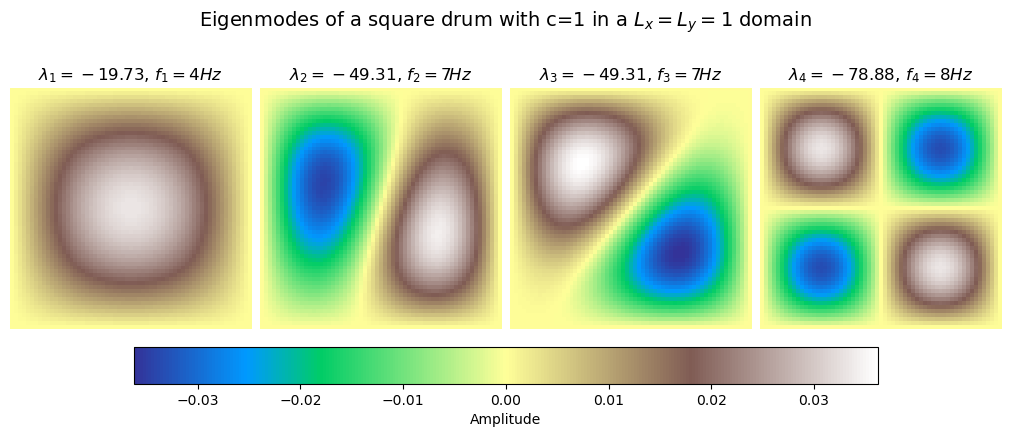

In [5]:
# Select only the edge cases we want to visualize
which_l = 'LM'
which_s = 'SM'
k = 4

# Parameters
Nx, Ny = 61, 61
Lx, Ly = 1, 1
title = f'Eigenmodes of a square drum with c=1 in a $L_x = L_y = {Ly}$ domain'

M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=True, k=k, which=which_l)
M, eigvals_s, eigvecs_s, eigfreqs_s = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='descending', sparse=True, k=k, which=which_s)

fig = vis_eigvecs(eigvecs_s, eigvals_s, eigfreqs_s, Nx, Ny, Lx, Ly, plot_shape=(1, k), title=title)
fig.savefig(f'{MEDIA_PATH}/eigvecs_square_{Nx}x{Ny}_L={Lx}x{Ly}_k={k}_which={which_s}.png')

Visualizing eigenmodes of a rectangular drum of size $L_x = 1$ and $L_y = 2$.

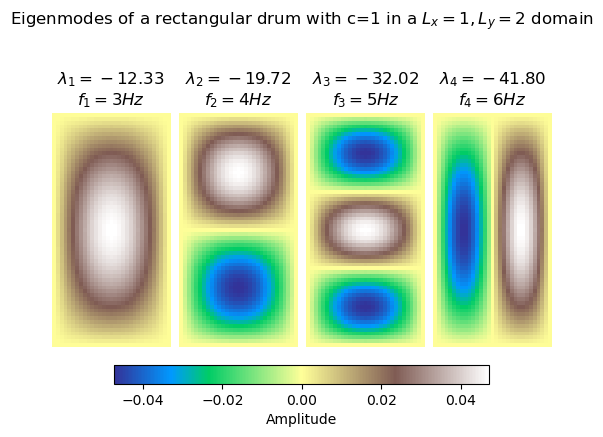

In [6]:
Nx, Ny = 31, 61
Lx, Ly = 1, 2
title = f'Eigenmodes of a rectangular drum with c=1 in a $L_x = {Lx}, L_y = {Ly}$ domain'

M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=True, k=k, which=which_l)
M, eigvals_s, eigvecs_s, eigfreqs_s = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='descending', sparse=True, k=k, which=which_s)

fig = vis_eigvecs(eigvecs_s, eigvals_s, eigfreqs_s, Nx, Ny, Lx, Ly, plot_shape=(1, k), title=title, titlesize=12)
fig.savefig(f'{MEDIA_PATH}/eigvecs_rectangle_{Nx}x{Ny}_L={Lx}x{Ly}_k={k}_which={which_s}.png')

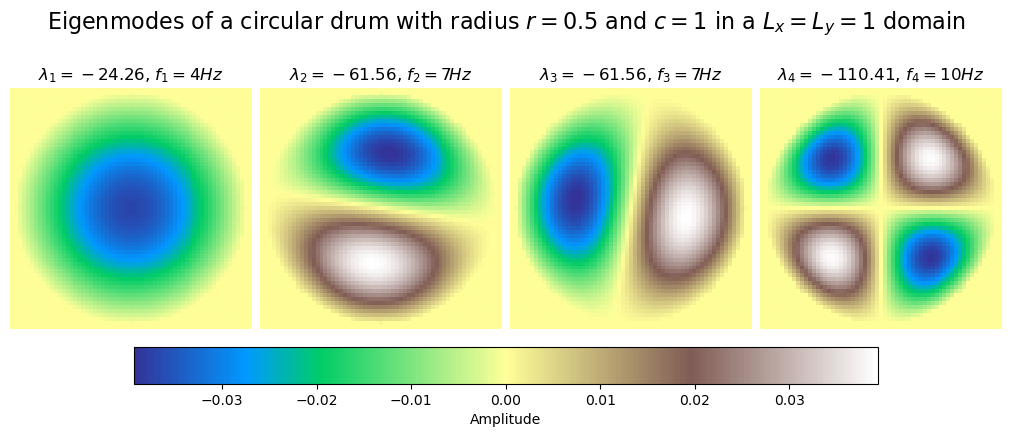

In [7]:
Nx, Ny = 61, 61
Lx, Ly = 1, 1
radius = 1/(2*Lx)
title = f'Eigenmodes of a circular drum with radius $r = {radius}$ and $c=1$ in a $L_x = L_y = {Ly}$ domain'
M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=radius, sort_order='ascending', sparse=True, k=k, which=which_l)
M, eigvals_s, eigvecs_s, eigfreqs_s = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=radius, sort_order='descending', sparse=True, k=200, which=which_s)
eigvals_s, eigvecs_s, eigfreqs_s = eigvals_s[eigfreqs_s > 0], eigvecs_s[:, eigfreqs_s > 0], eigfreqs_s[eigfreqs_s > 0]
eigvals_s, eigvecs_s, eigfreqs_s = eigvals_s[:k], eigvecs_s[:, :k], eigfreqs_s[:k]

fig = vis_eigvecs(eigvecs_s, eigvals_s, eigfreqs_s, Nx, Ny, Lx, Ly, plot_shape=(1, k), title=title, titlesize=16)
fig.savefig(f'{MEDIA_PATH}/eigvecs_circle_{Nx}x{Ny}_L={Lx}x{Ly}_radius={radius}_k={k}_which={which_s}.png')

Comparing time and memory performance of sparse vs. dense eigenvalue decomposition solvers

In [8]:
N_range = np.arange(5, 41, 1)
ks = [1, 5, 25]
N_sim = 10

times_dense = np.zeros((len(N_range), len(ks)))
memory_dense = np.zeros((len(N_range), len(ks)))
times_sparse = np.zeros((len(N_range), len(ks)))
memory_sparse = np.zeros((len(N_range), len(ks)))

if LOAD_CACHED_FILES_IF_AVAILABLE and os.path.exists(f'{DATA_PATH}/ex3_1_1_times_dense.npy'):
    times_dense = np.load(f'{DATA_PATH}/ex3_1_1_times_dense.npy')
    memory_dense = np.load(f'{DATA_PATH}/ex3_1_1_memory_dense.npy')
    times_sparse = np.load(f'{DATA_PATH}/ex3_1_1_times_sparse.npy')
    memory_sparse = np.load(f'{DATA_PATH}/ex3_1_1_memory_sparse.npy')
else:
    pbar = tqdm(total=len(N_range)*len(ks)*2, desc='Simulating across parameter space', unit='sim')
    for i, Nx in enumerate(N_range):
        for j, k in enumerate(ks):
            Ny = Nx
            N = (Nx-2)*(Ny-2)
            if k > N-2:
                times_dense[i, j], times_sparse[i, j] = np.nan, np.nan
                memory_dense[i, j], memory_sparse[i, j] = np.nan, np.nan
                pbar.update(2)
                continue

            time_dense = np.zeros((N_sim))
            for n in range(N_sim):
                start = time.time_ns()
                M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', k=k, which=which_l)
                end = time.time_ns()
                time_dense[n] = (end - start) / 1_000
            times_dense[i, j] = np.mean(time_dense)
            memory_dense[i, j] = size_in_bytes(M)
            pbar.update()

            time_sparse = np.zeros((N_sim))
            for n in range(N_sim):
                start = time.time_ns()
                M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=True, k=k, which=which_l)
                end = time.time_ns()
                time_sparse[n] = (end - start) / 1_000

            times_sparse[i, j] = np.mean(time_sparse)
            memory_sparse[i, j] = size_in_bytes(M)
            pbar.update()
            
    np.save(f'{DATA_PATH}/ex3_1_1_times_dense.npy', times_dense)
    np.save(f'{DATA_PATH}/ex3_1_1_memory_dense.npy', memory_dense)
    np.save(f'{DATA_PATH}/ex3_1_1_times_sparse.npy', times_sparse)
    np.save(f'{DATA_PATH}/ex3_1_1_memory_sparse.npy', memory_sparse)

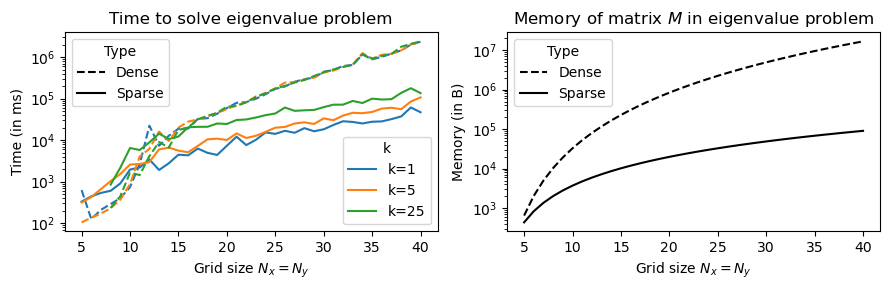

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
cmap = cm.get_cmap('viridis')
colors = ['tab:blue', 'tab:orange', 'tab:green']

ax = axs[0]
for i, k in enumerate(ks):
    color = colors[i]
    ax.plot(N_range, times_dense[:, i], linestyle='--', color=color)
    ax.plot(N_range, times_sparse[:, i], label=f'k={k}', linestyle='-', color=color)

ax.set_xlabel('Grid size $N_x=N_y$')
ax.set_ylabel('Time (in ms)')
ax.set_title('Time to solve eigenvalue problem')
ax.set_yscale('log')
first_legend = ax.legend(title='k', loc='lower right')
ax.add_artist(first_legend)
dense_line = mlines.Line2D([], [], color='black', linestyle='--', label='Dense')
sparse_line = mlines.Line2D([], [], color='black', linestyle='-', label='Sparse')
ax.legend(title='Type', handles=[dense_line, sparse_line], loc='upper left')

ax = axs[1]
ax.plot(N_range, memory_dense[:, 0], label=f'k={k}', linestyle='--', color='black')
ax.plot(N_range, memory_sparse[:, 0], label=f'k={k}', linestyle='-', color='black')
ax.set_xlabel('Grid size $N_x=N_y$')
ax.set_ylabel('Memory (in B)')
ax.set_title('Memory of matrix $M$ in eigenvalue problem')
ax.set_yscale('log')
dense_line = mlines.Line2D([], [], color='black', linestyle='--', label='Dense')
sparse_line = mlines.Line2D([], [], color='black', linestyle='-', label='Sparse')
ax.legend(title='Type', handles=[dense_line, sparse_line], loc='upper left')
plt.tight_layout()
plt.savefig(f'{MEDIA_PATH}/time_and_memory_comparison.png')

Visualizing effect of drum shapes, choice of spatial domain size $L$ and discretization $N_x$, $N_y$ on  eigenfrequency spectrums

In [10]:
Ls = np.array([0.1, 0.2, 0.5, 1.0, 2.0, 5.0])
Nx, Ny = 21, 21
N = (Nx-2)*(Ny-2)
k = N

eigfreqs_square = np.zeros((len(Ls), N))

radii = Ls/2
eigfreqs_circle = np.zeros((len(Ls), N))

Nx_rect, Ny_rect = int(Nx/np.sqrt(2)), int(Ny*np.sqrt(2))
N_rect = (Nx_rect-2)*(Ny_rect-2)
k_rect = N_rect
eigfreqs_rectangle = np.zeros((len(Ls), N_rect))

if LOAD_CACHED_FILES_IF_AVAILABLE and os.path.exists(f'{DATA_PATH}/ex3_1_1_eigfreqs_square.npy'):
    eigfreqs_square = np.load(f'{DATA_PATH}/ex3_1_1_eigfreqs_square.npy')
    eigfreqs_circle = np.load(f'{DATA_PATH}/ex3_1_1_eigfreqs_circle.npy')
    eigfreqs_rectangle = np.load(f'{DATA_PATH}/ex3_1_1_eigfreqs_rectangle.npy')
else:
    for i, (L, radius) in tqdm(enumerate(zip(Ls, radii))):
        Lx, Ly = L, L
        freqs = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', k=k, which=which_l)[-1]
        eigfreqs_square[i, :] = freqs
        freqs = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=radius, sort_order='ascending', k=k, which=which_l)[-1]
        eigfreqs_circle[i, :] = freqs
        freqs = solve_eigenvalue_problem(int(Nx/np.sqrt(2)), int(Ny*np.sqrt(2)), Lx, Ly*2, sort_order='ascending', k=k_rect, which=which_l)[-1]
        eigfreqs_rectangle[i, :] = freqs

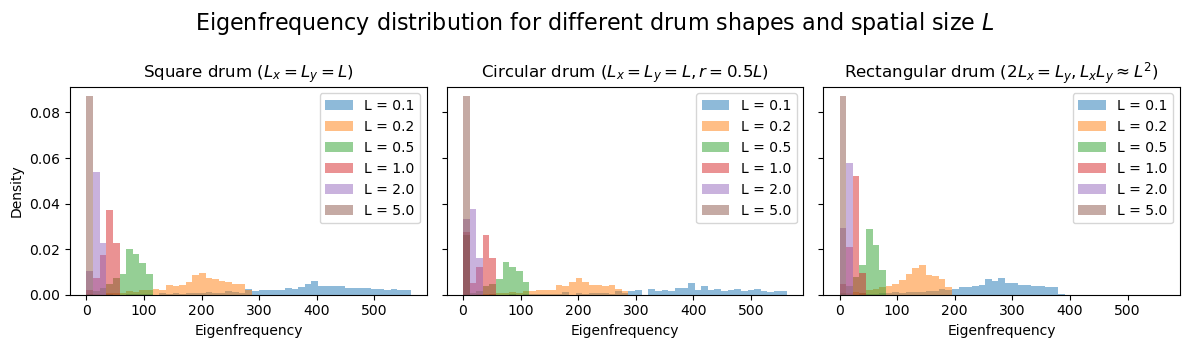

In [11]:
eigfreqs_list = [eigfreqs_square, eigfreqs_circle, eigfreqs_rectangle]
min_eigfreq = np.min([np.min(eigfreqs) for eigfreqs in eigfreqs_list])
max_eigfreq = np.max([np.max(eigfreqs) for eigfreqs in eigfreqs_list])
N_bins = 50
bin_edges = np.linspace(min_eigfreq, max_eigfreq, N_bins)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), layout='tight', sharey=True)
fig.suptitle('Eigenfrequency distribution for different drum shapes and spatial size $L$', fontsize=16)
for i, eigfreqs in enumerate(eigfreqs_list):
    ax = axs[i]
    for l in range(len(Ls)):
        ax.hist(eigfreqs[l, :], bins=bin_edges, alpha=0.5, label=f'L = {Ls[l]}', density=True)
    ax.set_title(['Square drum ($L_x=L_y=L$)', 'Circular drum ($L_x=L_y=L, r=0.5 L$)', 'Rectangular drum ($2L_x=L_y, L_x L_y \\approx L^2$)'][i])
    ax.set_xlabel('Eigenfrequency')
    ax.legend()
axs[0].set_ylabel('Density')
fig.savefig(f'{MEDIA_PATH}/eigfreqs_distribution_comparison_shape_L.png')

In [12]:
L = 1.0
Nxs = np.arange(5, 51, 1)
Nys = Nxs
k = (Nxs-2)*(Nys-2)

eigfreqs = np.zeros((len(Nxs), k.max()))

if LOAD_CACHED_FILES_IF_AVAILABLE and os.path.exists(f'{DATA_PATH}/ex3_1_1_eigfreqs.npy'):
    eigfreqs = np.load(f'{DATA_PATH}/ex3_1_1_eigfreqs.npy')
else:
    for i, (Nx, Ny) in tqdm(enumerate(zip(Nxs, Nys)), total=len(Nxs)):
        N = (Nx-2)*(Ny-2)
        freqs = solve_eigenvalue_problem(Nx, Ny, L, L, sort_order='ascending', k=N, which=which_l)[-1]
        eigfreqs[i, :N] = freqs
    np.save(f'{DATA_PATH}/ex3_1_1_eigfreqs.npy', eigfreqs)

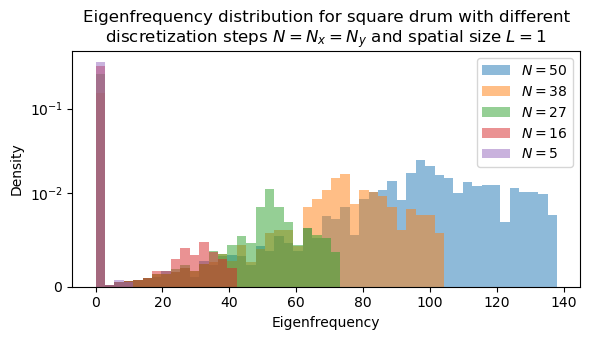

In [13]:
min_eigfreq = np.min(eigfreqs)
max_eigfreq = np.max(eigfreqs)
N_bins = 50
bin_edges = np.linspace(min_eigfreq, max_eigfreq, N_bins)

plt.figure(figsize=(6, 3.5), layout='tight')

for n in np.linspace(0, len(Nxs)-1, 5, dtype=int)[::-1]:
    plt.hist(eigfreqs[n, :], bins=bin_edges, density=True, alpha=0.5, label=f'$N={Nxs[n]}$')

plt.xlabel('Eigenfrequency')
plt.ylabel('Density')
plt.yscale('symlog', linthresh=1e-2)
plt.legend(loc='upper right')
plt.title('Eigenfrequency distribution for square drum with different\ndiscretization steps $N = N_x = N_y$ and spatial size $L=1$')
plt.savefig(f'{MEDIA_PATH}/eigfreqs_distribution_comparison_discretization.png')